In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import seaborn as sns

markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', 'x', '+', '<', '>', '1', '2', '3', '4']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


skdf = load_iris(as_frame=False)
df_iris = pd.DataFrame(skdf["data"], columns=skdf['feature_names']) 
target = pd.Series(skdf["target"], name="target")
df = df_iris.join(target)
X_pca = pd.DataFrame(PCA(n_components=2).fit_transform(StandardScaler().fit_transform(df_iris)), columns=['PC1', 'PC2'])
fields = X_pca.columns.tolist()

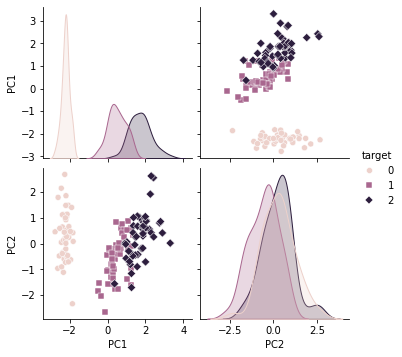

In [43]:
sns.pairplot(X_pca.join(target), hue='target', diag_kind='kde', markers=markers[:3])
plt.show()

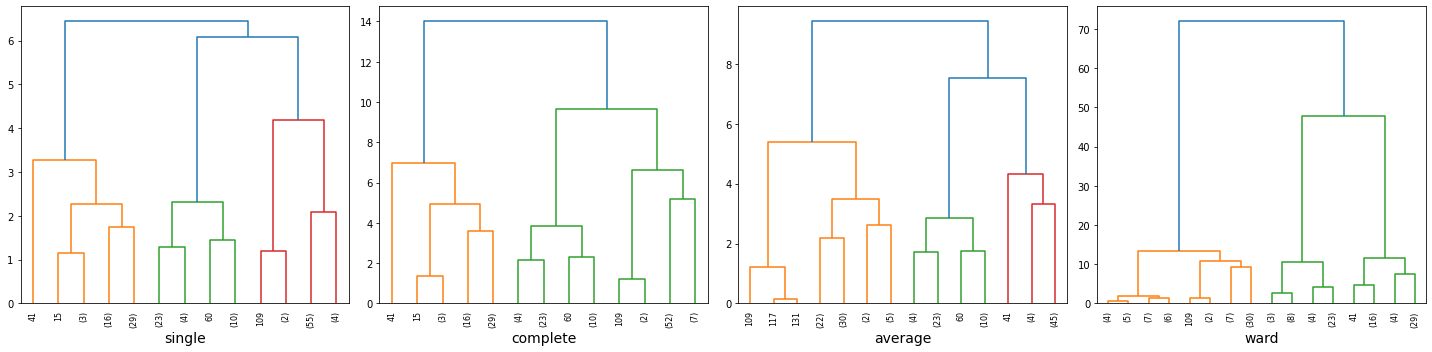

In [59]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
ms = ['single', 'complete', 'average', 'ward']
dms = []
Zs = []
for m, ax in zip(ms, axs):
    dm = pdist(X_pca, metric='euclidean') #single, complete, average, and ward
    dms.append(dm)
    Z = linkage(dm, method=m)#single, complete, average, and ward
    d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=8, leaf_rotation=90, ax=ax, truncate_mode="level", p=3)

    ax.set_xlabel(m, fontsize=14)
    Zs.append(Z)


plt.tight_layout()
plt.show()


Silouette score para  single = 0.7553074237148553


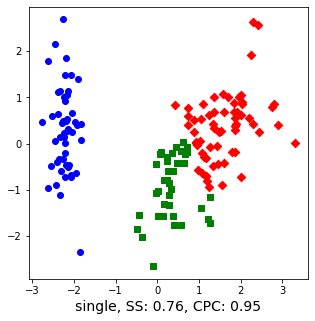

Silouette score para  complete = 0.7553074237148553


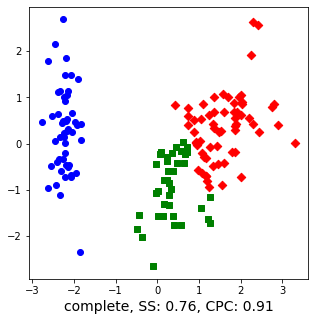

Silouette score para  average = 0.7553074237148553


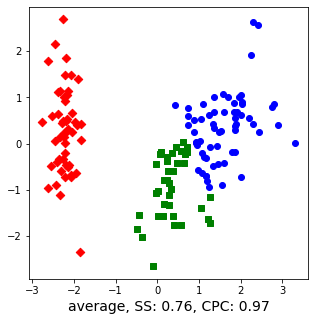

Silouette score para  ward = 0.7553074237148553


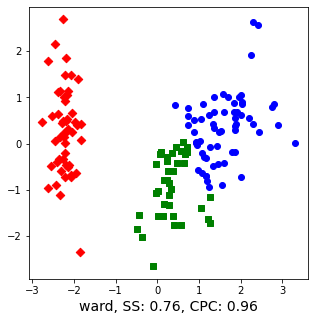

In [60]:

cgrupos = 3
ms = ['single', 'complete', 'average', 'ward']
for m, Z in zip(ms, Zs):
    memb = fcluster(Z, cgrupos, criterion='maxclust')
    memb = pd.Series(memb, index=X_pca.index)
    X_pca["Cluster"] = memb

    ss = metrics.silhouette_score(X_pca, labels=memb, metric='euclidean')
    print("Silouette score para ", m, "=", ss)

    uet = np.unique(X_pca["Cluster"])
   
    fig, ax = plt.subplots(figsize=(5, 5))
    i = 0
    for e in uet:
        x = X_pca[X_pca["Cluster"]==e][X_pca.columns[0]]
        y = X_pca[X_pca["Cluster"]==e][X_pca.columns[1]]
        for index, row in X_pca[X_pca["Cluster"]==e].iterrows():
            ax.scatter(row[X_pca.columns[0]],row[X_pca.columns[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])
        cpc, cp = cophenet(linkage(dm, method=m), dm)
        ax.set_xlabel(m+", SS: "+"{:2.2f}".format(ss)+", CPC: "+"{:2.2f}".format(cpc), fontsize=14)       
        i+=1
        #plt.scatter(x, y, marker=markers[e%len(markers)], color=colors[e%len(colors)], label='Group'+str(e))
    #plt.legend()
    plt.show()


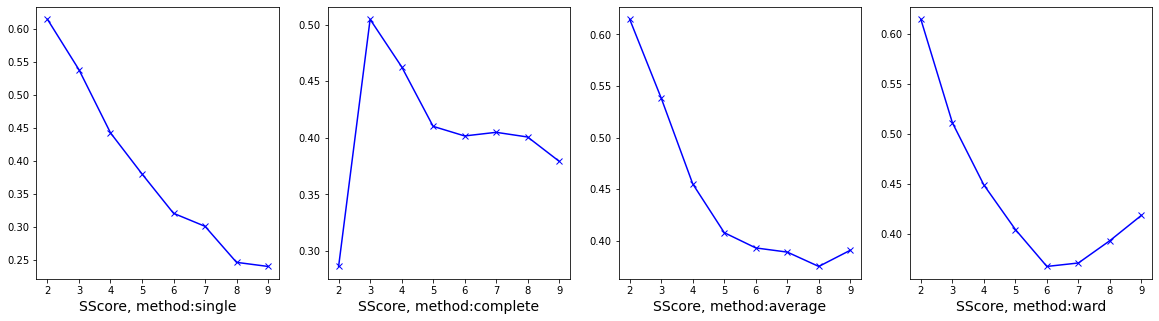

El maximo valor esta en  single 2


In [48]:
groups = range(2,10,1)
ms = ['single', 'complete', 'average', 'ward']
fig, axs = plt.subplots(1, len(ms), figsize=(20, 5))

results = []
ssmax = ('', 0, None, None, -1)
sscores = []

for m, mv, ax in zip(ms, range(0,len(ms)), axs):
    sscores = []
    for i in groups:
        #pdist calcula la matriz de distancias
        dm = pdist(X_pca[fields], metric='euclidean') #single, complete, average, and ward
        #linkage calcula el linkage, Z es una matriz donde cada fila es un enlace entre dos grupos
        Z = linkage(dm, method=m)#single, complete, average, and ward
        # Seleciono cantidad de grupos...es i
        memb = fcluster(Z, i, criterion='maxclust')
        X_pca["cluster_"+m+"_"+str(i)] = memb
        # Calculo el silhouette score
        ss = metrics.silhouette_score(X_pca[fields], labels=memb, metric='euclidean')
        val = (m, i, dm, Z, ss)
        results.append(val)
        if val[4]>ssmax[4]:
            ssmax = val
        sscores.append(ss)
    
    ax.plot(groups,sscores,'bx-')
    ax.set_xlabel("SScore, method:{}".format(m), fontsize=14)
        
plt.show()


print("El maximo valor esta en ", ssmax[0], ssmax[1])

El Silhouette Score es una medida de cercanía de los puntos al cluster donde quedaron agrupados y en comparación con otros cluster. Va entre -1 y 1 y mientras mayor sea el valor puede considerarse un mejor agrupamiento.

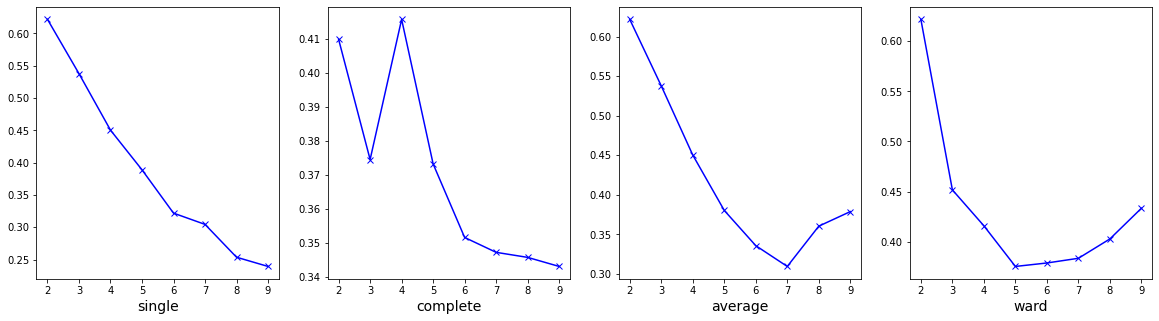

El máximo valor esta en  single 2 y es de  0.6218386635623805


In [49]:
def distancia_del_rey(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return max(abs(x1 - x2), abs(y1 - y2))

ms = ['single', 'complete', 'average', 'ward']
groups = range(2,10,1)
fig, axs = plt.subplots(1, len(ms), figsize=(20, 5))

results = []
ssmax = ('', 0, None, None, -1)
sscores = []
Zs = []
for m, mv, ax in zip(ms, range(0,len(ms)), axs):
    sscores = []
    Z = linkage(dm, method=m)#single, complete, average, and ward
    for i in groups:
        dm = pdist(X_pca[fields], metric=distancia_del_rey) #single, complete, average, and ward
        memb = fcluster(Z, i, criterion='maxclust')
        X_pca["cluster_"+m+"_"+str(i)] = memb
        ss = metrics.silhouette_score(X_pca[fields], labels=memb, metric=distancia_del_rey)
        val = (m, i, dm, Z, ss)
        results.append(val)
        if val[4]>ssmax[4]:
            ssmax = val
        sscores.append(ss)
    Zs.append(Z)
    
    ax.plot(groups,sscores,'bx-')
    ax.set_xlabel(m, fontsize=14)
        
plt.show()

print("El máximo valor esta en ", ssmax[0], ssmax[1], "y es de ", ssmax[4])

Si establecemos arbitrariamente en 3 la cantidad de clusters si podemos mediante Silhouette quedarnos con el mejor agrupamiento

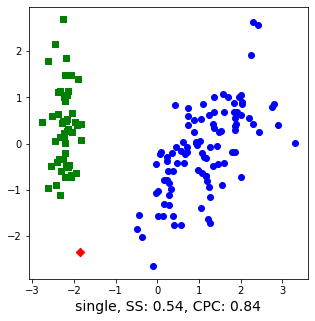

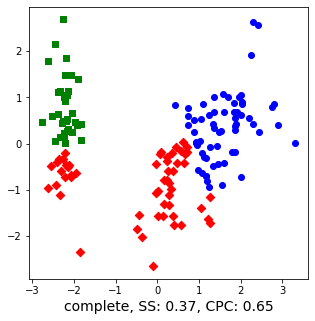

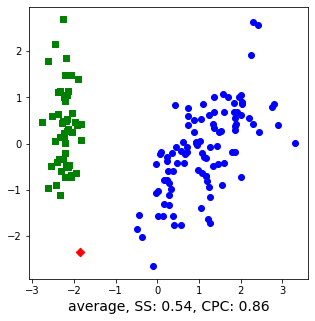

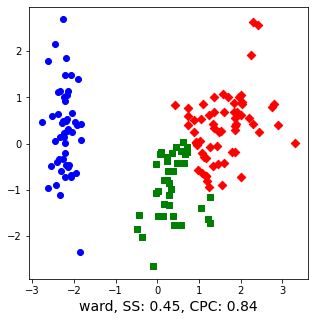

In [51]:
cgrupos = 3
ms = ['single', 'complete', 'average', 'ward']
for m, Z in zip(ms, Zs):
    memb = fcluster(Z, cgrupos, criterion='maxclust')
    memb = pd.Series(memb, index=X_pca.index)
    X_pca["Cluster"] = memb

    ss = metrics.silhouette_score(X_pca[fields], labels=memb, metric=distancia_del_rey)
    #print("Silouette score para ", m, "=", ss)

    uet = np.unique(X_pca["Cluster"])

    fig, ax = plt.subplots(figsize=(5, 5))
    i = 0
    for e in uet:
        x = X_pca[X_pca["Cluster"]==e][fields[0]]
        y = X_pca[X_pca["Cluster"]==e][fields[1]]
        for index, row in X_pca[X_pca["Cluster"]==e].iterrows():
            ax.scatter(row[fields[0]],row[fields[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])
        
        cpc, cp = cophenet(linkage(dm, method=m), dm)

        
        ax.set_xlabel(m+", SS: "+"{:2.2f}".format(ss)+", CPC: "+"{:2.2f}".format(cpc), fontsize=14)    
        i+=1
        #plt.scatter(x, y, marker=markers[e%len(markers)], color=colors[e%len(colors)], label='Group'+str(e))
    #plt.legend()
    plt.show()

In [32]:
from scipy.spatial import distance

# Obtén la lista de todas las métricas de distancia disponibles
all_distance_metrics = distance._METRICS.keys()

# Imprime la lista de métricas de distancia
for metric in all_distance_metrics:
    print(metric)

    

braycurtis
canberra
chebyshev
cityblock
correlation
cosine
dice
euclidean
hamming
jaccard
jensenshannon
kulczynski1
mahalanobis
minkowski
rogerstanimoto
russellrao
seuclidean
sokalmichener
sokalsneath
sqeuclidean
yule


--------

Pruebo con todas las combinaciones. Igualmente no llego a tener 3 clusters como mejor opción.

In [52]:
skdf = load_iris(as_frame=False)
df_iris = pd.DataFrame(skdf["data"], columns=skdf['feature_names']) 
target = pd.Series(skdf["target"], name="target")
df = df_iris.join(target)
X_pca = pd.DataFrame(PCA(n_components=2).fit_transform(StandardScaler().fit_transform(df_iris)), columns=['PC1', 'PC2'])
fields = X_pca.columns.tolist()

results = []
ssmax = ('', 0, None, None, -1)
scores = []


cgrupos = range(2,10,1)
ms = ['single', 'complete', 'average', 'ward']
mmetrics = ['euclidean', 'cityblock', distancia_del_rey]

for m in ms:
    for metric in mmetrics:
        dm = pdist(X_pca[fields], metric=metric)
        Z = linkage(dm, method=m)
        for g in cgrupos:
            #Los grupos son luego de tener el dendrograma hecho, no es necesario volver a calcularlo
            memb = fcluster(Z, g, criterion='maxclust') #criterion='maxclust' para obtener un número fijo de grupos
            X_pca["cluster_"+m+"_"+str(i)] = memb
            ss = metrics.silhouette_score(X_pca[fields], labels=memb, metric='euclidean')
            c_score, coph_dist = cophenet(Z, dm)
            results.append(val)
            val = {"method": m, "groups": g, "metric": metric, "silhouette_score": ss, "cophenetic_correlation": c_score}
            
            scores.append(val)



In [ ]:
df_results = pd.DataFrame(scores)
df_results.sort_values(by=["silhouette_score", "cophenetic_correlation"], ascending=False)

In [55]:
df_results.sort_values(by=["silhouette_score"], ascending=False)
df_results.sort_values(by=["cophenetic_correlation"], ascending=False)

,method,groups,metric,silhouette_score,cophenetic_correlation
64,average,2,<function distancia_del_rey at 0x000001B840FC3...,0.614520,0.864441
65,average,3,<function distancia_del_rey at 0x000001B840FC3...,0.538124,0.864441
66,average,4,<function distancia_del_rey at 0x000001B840FC3...,0.442485,0.864441
67,average,5,<function distancia_del_rey at 0x000001B840FC3...,0.373113,0.864441
68,average,6,<function distancia_del_rey at 0x000001B840FC3...,0.324652,0.864441
...,...,...,...,...,...
43,complete,5,<function distancia_del_rey at 0x000001B840FC3...,0.379593,0.650984
44,complete,6,<function distancia_del_rey at 0x000001B840FC3...,0.342972,0.650984
45,complete,7,<function distancia_del_rey at 0x000001B840FC3...,0.338294,0.650984
46,complete,8,<function distancia_del_rey at 0x000001B840FC3...,0.335568,0.650984


¿Con que método me quedo?

In [56]:
df_results.groupby(["method", "metric"]).agg({"silhouette_score": "max", "cophenetic_correlation": "max"}).reset_index().sort_values(by=["silhouette_score"], ascending=False)

,method,metric,silhouette_score,cophenetic_correlation
0,average,<function distancia_del_rey at 0x000001B840FC3...,0.614520,0.864441
1,average,cityblock,0.614520,0.837307
2,average,euclidean,0.614520,0.852283
4,complete,cityblock,0.614520,0.778488
6,single,<function distancia_del_rey at 0x000001B840FC3...,0.614520,0.843449
7,single,cityblock,0.614520,0.793994
8,single,euclidean,0.614520,0.836265
9,ward,<function distancia_del_rey at 0x000001B840FC3...,0.614520,0.836927
10,ward,cityblock,0.614520,0.811352
11,ward,euclidean,0.614520,0.840341


Me quedo con average, distancia del rey

In [57]:
df_average_rey = df_results[(df_results["method"]=="average") & (~df_results["metric"].isin(["euclidean", "cityblock"]))]

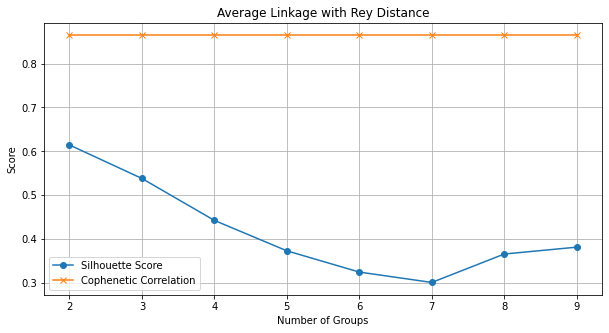

In [58]:
df_average_rey
plt.figure(figsize=(10, 5))
plt.plot(df_average_rey["groups"], df_average_rey["silhouette_score"], marker='o', label='Silhouette Score')
plt.plot(df_average_rey["groups"], df_average_rey["cophenetic_correlation"], marker='x', label='Cophenetic Correlation')
plt.xlabel('Number of Groups')  
plt.ylabel('Score')
plt.title('Average Linkage with Rey Distance')
plt.legend()
plt.grid()
plt.show()